In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate sessions with pfc or mec

In [6]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


## what mazes are there?

In [11]:
epochs_df = pd.DataFrame()
for basepath in df_sessions.basepath:
    epochs_df_temp = loading.load_epoch(basepath)
    idx,_ = functions.find_pre_task_post(epochs_df_temp.environment)
    if idx is None:
        continue
    epochs_df_temp = epochs_df_temp[idx]
    epochs_df_temp["basepath"] = basepath
    epochs_df = pd.concat([epochs_df, epochs_df_temp], ignore_index=True)

In [12]:
epochs_df.environment.unique()

array(['sleep', 'linear', 'cheeseboard', 'box', 'Mwheel', 'bigSquare',
       'midSquare', 'ZigZag', 'wmaze', 'tmaze'], dtype=object)

In [4]:
# df_sessions.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\hp_cortex_assembly_reactivation_sessions.csv")

# main analysis

In [7]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress"
    )

batch_analysis.run(
    sessions,
    save_path,
    assembly_multi_region.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
prop_df, assembly_df, df_strength = assembly_multi_region.load_results(save_path)

100%|██████████| 110/110 [00:04<00:00, 22.94it/s]


Loading results...


# Find biases with proportion of cross-region assemblies

## remove rows with not enough data

In [8]:
prop_df = prop_df[~((prop_df.n_pfc == 0) & prop_df.labels.str.contains("PFC"))]
prop_df = prop_df[~((prop_df.n_mec == 0) & prop_df.labels.str.contains("MEC"))]
prop_df = prop_df[~((prop_df.n_sup == 0) & prop_df.labels.str.contains("Superficial"))]
prop_df = prop_df[~((prop_df.n_deep == 0) & prop_df.labels.str.contains("Deep"))]
prop_df = prop_df[~(prop_df.n_assemblies == 0)]

prop_df = prop_df[~((prop_df.n_pfc < 2) & prop_df.labels.str.contains("PFC"))]
prop_df = prop_df[~((prop_df.n_mec < 2) & prop_df.labels.str.contains("MEC"))]
prop_df = prop_df[~((prop_df.n_sup < 2) & prop_df.labels.str.contains("Superficial"))]
prop_df = prop_df[~((prop_df.n_deep < 2) & prop_df.labels.str.contains("Deep"))]

prop_df['constant'] = 1
prop_df

,prop_cross_region,n_cross_region,labels,n_deep,n_sup,n_mec,n_pfc,n_assemblies,basepath,constant
15,0.166667,1,Deep MEC,22,1,10,0,6,Z:\Data\AYAold\AYA7\day19,1
17,0.000000,0,Superficial MEC,55,2,38,0,6,Z:\Data\AYAold\AYA7\day20,1
19,0.666667,4,Deep MEC,55,2,38,0,6,Z:\Data\AYAold\AYA7\day20,1
21,0.307692,4,Superficial MEC,62,11,50,0,13,Z:\Data\AYAold\AYA7\day24,1
23,0.538462,7,Deep MEC,62,11,50,0,13,Z:\Data\AYAold\AYA7\day24,1
...,...,...,...,...,...,...,...,...,...,...
285,0.500000,2,Superficial MEC,0,16,4,0,4,Z:\Data\Kenji\i01_maze01_MS.001_003,1
292,0.250000,2,Superficial PFC,19,14,0,13,8,Z:\Data\ORproject\OR18\day1,1
294,0.125000,1,Deep PFC,19,14,0,13,8,Z:\Data\ORproject\OR18\day1,1
296,0.000000,0,Superficial PFC,14,3,0,15,6,Z:\Data\ORproject\OR18\day2,1


## save prop df 

In [93]:
prop_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_prop_df.csv")

## use glm to estimate deep sup differences

### MEC

In [515]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
temp_df = prop_df[(prop_df.labels == "Deep MEC") | (prop_df.labels == "Superficial MEC")] 
glm = smf.glm(
    "prop_cross_region ~ labels",
    data=temp_df,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(temp_df["n_assemblies"]),
)
res_f = glm.fit()
print(res_f.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      prop_cross_region   No. Observations:                  104
Model:                            GLM   Df Residuals:                      754
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -266.41
Date:                Wed, 20 Jul 2022   Deviance:                       230.54
Time:                        14:06:27   Pearson chi2:                     244.
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0005352
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### PFC

In [516]:
temp_df = prop_df[(prop_df.labels == "Deep PFC") | (prop_df.labels == "Superficial PFC")] 
glm = smf.glm(
    "prop_cross_region ~ labels",
    data=temp_df,
    family=sm.families.Binomial(),
    freq_weights=np.asarray(temp_df["n_assemblies"]),
)
res_f = glm.fit()
print(res_f.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      prop_cross_region   No. Observations:                   23
Model:                            GLM   Df Residuals:                      239
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -86.829
Date:                Wed, 20 Jul 2022   Deviance:                       23.549
Time:                        14:06:30   Pearson chi2:                     18.4
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2675
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## Overall proportion of assemblies

In [517]:
for l in prop_df.labels.unique():
    print(
        l,
        (prop_df[prop_df.labels.str.contains(l)].n_cross_region.sum())
        / prop_df[prop_df.labels.str.contains(l)].n_assemblies.sum(),
    )


Deep MEC 0.16449086161879894
Superficial MEC 0.1581769436997319
Superficial PFC 0.14655172413793102
Deep PFC 0.288


## plot to show effect

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1_Deep PFC v.s. 1_Superficial PFC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.097e-02 U_stat=1.075e+02
1_Deep MEC v.s. 1_Superficial MEC: Mann-Whitney-Wilcoxon test two-sided, P_val=9.096e-01 U_stat=1.368e+03


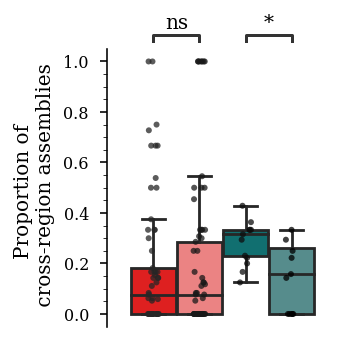

In [518]:
def reindex_df(df, weight_col):
    """expand the dataframe to prepare for resampling
    result is 1 row per count per sample"""
    df = df.reindex(df.index.repeat(df[weight_col]))
    df.reset_index(drop=True, inplace=True)
    return df


def weighted_boxplot(df, weight_col):
    sns.boxplot(
        x="constant",
        y="prop_cross_region",
        hue="labels",
        hue_order=group_colors.keys(),
        showfliers=False,
        data=reindex_df(df, weight_col=weight_col),
        saturation=1
    )

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
group_colors = {
    "Deep MEC": "#de2020",
    "Superficial MEC": "#eb8383",
    "Deep PFC": "#116f70",
    "Superficial PFC": "#568c8c",
}

sns.set_palette(sns.color_palette(group_colors.values()))

ax = plt.gca()

weighted_boxplot(prop_df, "n_assemblies")

sns.stripplot(
    x="constant",
    y="prop_cross_region",
    hue="labels",
    dodge=True,
    color="k",
    hue_order=group_colors.keys(),
    data=prop_df,
    size=3,alpha=.75,
    ax=ax,
)

plt.ylabel("Proportion of \n cross-region assemblies")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
# plt.grid()
sns.despine(bottom=True)
# turn off x axis
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel("")
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.get_legend().remove()


box_pairs = [
    ((1, "Deep MEC"), (1, "Superficial MEC")),
    ((1, "Deep PFC"), (1, "Superficial PFC")),
]
add_stat_annotation(
    plt.gca(),
    data=prop_df,
    x="constant",
    y="prop_cross_region",
    hue="labels",
    hue_order=group_colors.keys(),
    box_pairs=box_pairs,
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    verbose=1,
    comparisons_correction=None
)

plt.savefig(
    os.path.join(fig_save_path, "prop_cross_region_assemblies.svg"),
    dpi=300,
    bbox_inches="tight",
)
# locs, labels = plt.xticks()

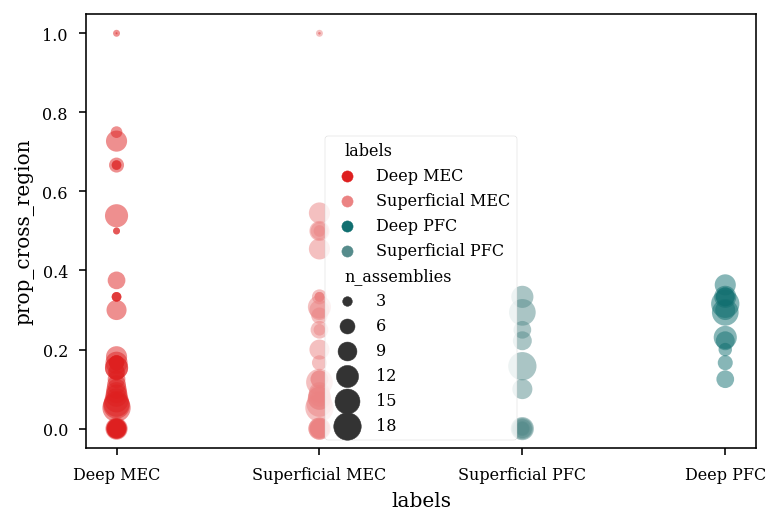

In [67]:
g = sns.scatterplot(
    x="labels",
    y="prop_cross_region",
    hue="labels",
    hue_order=group_colors.keys(),
    data=prop_df,
    size="n_assemblies",
    linewidth=0,
    sizes=(1, 200),
    alpha=0.5,
)

### alternative plot to show effect with weighted points

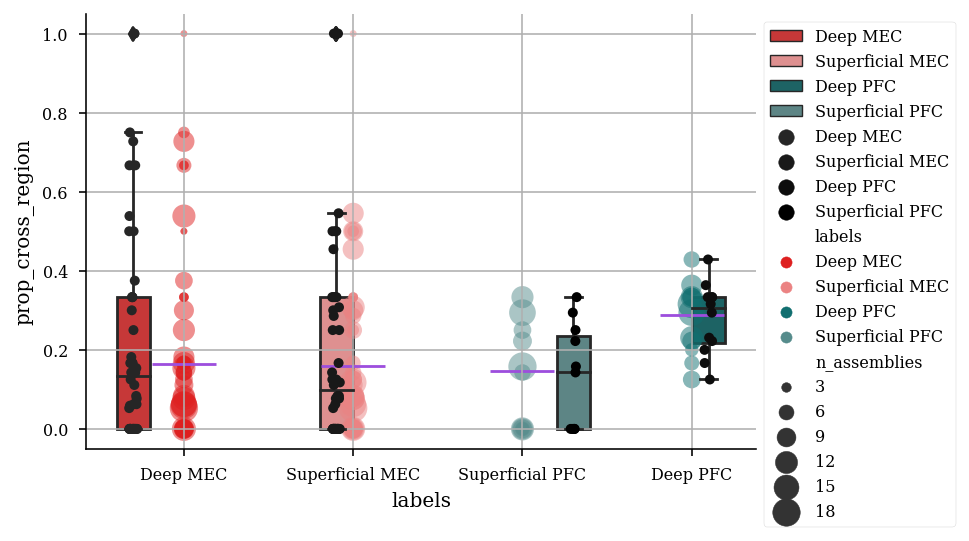

In [519]:
def weighted_average_m1(distribution, weights):
    return sum([distribution[i] * weights[i] for i in range(len(distribution))]) / sum(
        weights
    )

group_colors = {
    "Deep MEC": "#de2020",
    "Superficial MEC": "#eb8383",
    "Deep PFC": "#116f70",
    "Superficial PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))
plt.figure()
ax = plt.gca()
sns.boxplot(x="labels", y="prop_cross_region",hue="labels", dodge=True, hue_order=group_colors.keys(),data=prop_df,ax=ax)
sns.stripplot(x="labels", y="prop_cross_region",hue="labels", dodge=True,color='k',hue_order=group_colors.keys(),data=prop_df,ax=ax)

g = sns.scatterplot(
    x="labels",
    y="prop_cross_region",
    hue="labels",
    hue_order=group_colors.keys(),
    data=prop_df,
    size="n_assemblies",
    linewidth=0,
    sizes=(1, 200),
    alpha=0.5,
    ax=ax
)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Superficial MEC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Superficial MEC")].n_assemblies.values,
)
plt.scatter("Superficial MEC",mean,marker="_",color='#9d4edd',s=1000)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Deep MEC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Deep MEC")].n_assemblies.values,
)
plt.scatter("Deep MEC",mean,marker="_",color='#9d4edd',s=1000)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Superficial PFC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Superficial PFC")].n_assemblies.values,
)
plt.scatter("Superficial PFC",mean,marker="_",color='#9d4edd',s=1000)

mean = weighted_average_m1(
    prop_df[prop_df.labels.str.contains("Deep PFC")].prop_cross_region.values,
    prop_df[prop_df.labels.str.contains("Deep PFC")].n_assemblies.values,
)
plt.scatter("Deep PFC",mean,marker="_",color='#9d4edd',s=1000)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
sns.despine()

# Estimate reactivation

### assemblies have multiple cross region sig members

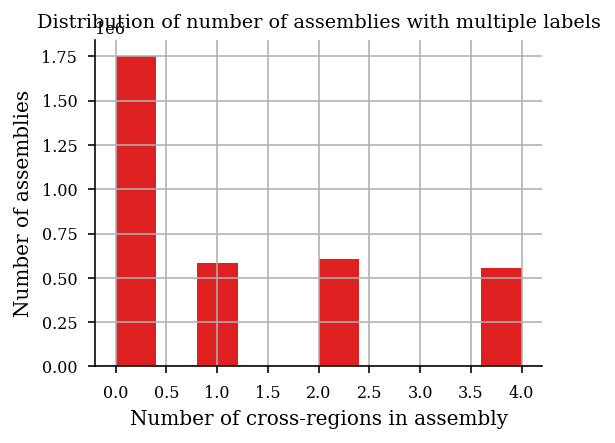

In [520]:
labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

pd.Series(df_strength[labels].sum(axis=1)).plot(
    kind="hist",
    bins=10,
    figsize=(4, 3),
    title="Distribution of number of assemblies with multiple labels",
    grid=True,
    
)
plt.ylabel("Number of assemblies")
plt.xlabel("Number of cross-regions in assembly")
# plt.hist(df_strength[labels].sum(axis=1))
sns.despine()
plt.show()


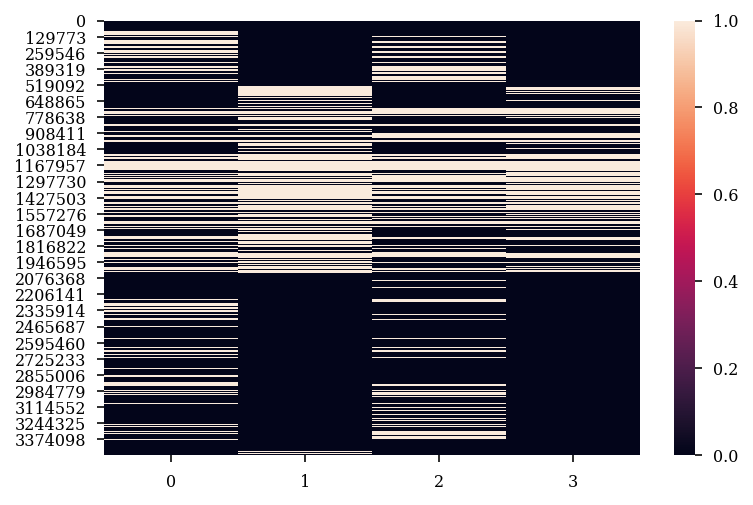

In [521]:
sns.heatmap(df_strength[labels].values)
plt.show()

In [522]:
df_strength[df_strength[labels].sum(axis=1) == 4].basepath.unique()

array(['Z:\\Data\\HMC1\\day10', 'Z:\\Data\\HMC1\\day12',
       'Z:\\Data\\HMC1\\day13', 'Z:\\Data\\HMC1\\day8',
       'Z:\\Data\\HMC1\\day9'], dtype=object)

## add idx for assemblies with single cross region sig members

In [523]:
df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1
df_strength.head()

,strength,assembly_n,ripple_n,sig,epoch,deep_mec,deep_pfc,superficial_mec,superficial_pfc,basepath,single_cross_region
0,0.005845,0.0,0.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False
1,0.067684,0.0,1.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False
2,0.013762,0.0,2.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False
3,0.126700,0.0,3.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False
4,0.003558,0.0,4.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False


## only 15% of assemblies have single cross region sig members

In [524]:
df_strength["single_cross_region"].sum() / df_strength["single_cross_region"].shape[0]

0.16689565300777887

## add labels for single members

In [525]:
out = [labels[val] for val in np.argmax(df_strength[labels].values,axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[df_strength.single_cross_region==False,"single_cross_region_label"] = 'unknown'
df_strength

,strength,assembly_n,ripple_n,sig,epoch,deep_mec,deep_pfc,superficial_mec,superficial_pfc,basepath,single_cross_region,single_cross_region_label
0,0.005845,0.0,0.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False,unknown
1,0.067684,0.0,1.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False,unknown
2,0.013762,0.0,2.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False,unknown
3,0.126700,0.0,3.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False,unknown
4,0.003558,0.0,4.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\AYAold\AYA10\day27,False,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
3503843,1.137374,7.0,1473.0,1.0,post,0.0,1.0,0.0,0.0,Z:\Data\ORproject\OR18\day2,True,deep_pfc
3503844,0.955363,7.0,1474.0,1.0,post,0.0,1.0,0.0,0.0,Z:\Data\ORproject\OR18\day2,True,deep_pfc
3503845,0.163192,7.0,1475.0,1.0,post,0.0,1.0,0.0,0.0,Z:\Data\ORproject\OR18\day2,True,deep_pfc
3503846,0.137198,7.0,1476.0,1.0,post,0.0,1.0,0.0,0.0,Z:\Data\ORproject\OR18\day2,True,deep_pfc


In [526]:
df_strength.groupby(["single_cross_region_label"]).basepath.count()

single_cross_region_label
deep_mec            202019
deep_pfc            174758
superficial_mec     187250
superficial_pfc      20750
unknown            2919071
Name: basepath, dtype: int64

In [527]:
# find basepath with single cross-region for each combination of labels
df_strength.groupby(["single_cross_region_label"]).basepath.unique()
n_cross_regions = []
for basepath in df_strength.basepath.unique():

    n_cross_regions.append(
        sum(
            [
                any(
                    df_strength[
                        df_strength.basepath == basepath
                    ].single_cross_region_label
                    == "deep_mec"
                ),
                any(
                    df_strength[
                        df_strength.basepath == basepath
                    ].single_cross_region_label
                    == "superficial_mec"
                ),
                any(
                    df_strength[
                        df_strength.basepath == basepath
                    ].single_cross_region_label
                    == "deep_pfc"
                ),
                any(
                    df_strength[
                        df_strength.basepath == basepath
                    ].single_cross_region_label
                    == "superficial_pfc"
                ),
            ]
        )
    )
    if n_cross_regions[-1] > 3:
        print(basepath)
    # if (
    #     any(
    #         df_strength[df_strength.basepath == basepath].single_cross_region_label
    #         == "deep_mec"
    #     )
    #     & any(
    #         df_strength[df_strength.basepath == basepath].single_cross_region_label
    #         == "superficial_mec"
    #     )
    #     & any(
    #         df_strength[df_strength.basepath == basepath].single_cross_region_label
    #         == "deep_pfc"
    #     )
    #     & any(
    #         df_strength[df_strength.basepath == basepath].single_cross_region_label
    #         == "superficial_pfc"
    #     )
    # ):
    #     print(basepath)


In [528]:
df_strength.basepath.unique()[np.argmax(n_cross_regions)]

'Z:\\Data\\HMC1\\day12'

## pre task post plot with assembly strength per cross region assembly

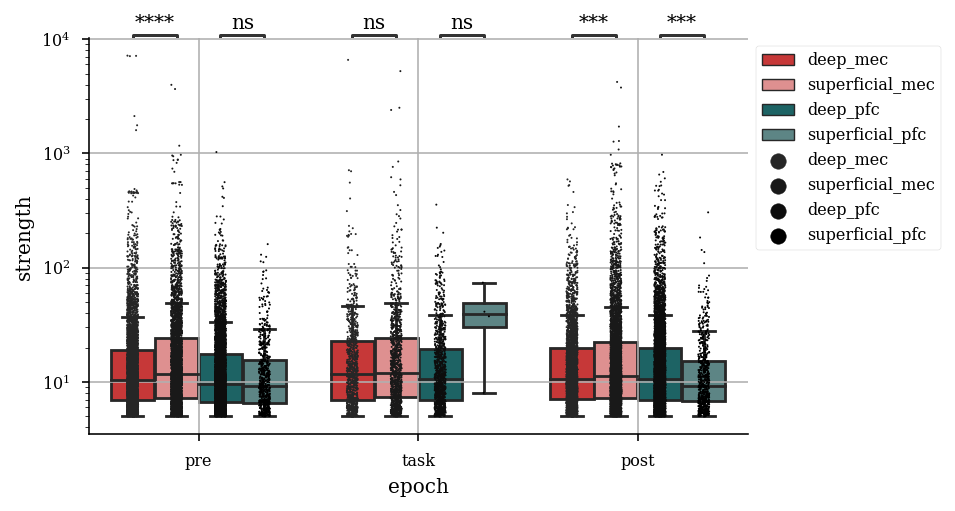

In [529]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=1, subplots=(1, 1)), edgecolor=None
)
group_colors = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "superficial_pfc": "#568c8c",
}

sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    hue="single_cross_region_label",
    hue_order=group_colors.keys(),
    y="strength",
    showfliers=False,
    data=df_strength[(df_strength.sig==1) & (df_strength.strength > 5) & (df_strength.single_cross_region_label != 'unknown')],
)
sns.stripplot(
    x="epoch",
    hue="single_cross_region_label",
    y="strength",
    data=df_strength[(df_strength.sig==1) & (df_strength.strength > 5) & (df_strength.single_cross_region_label != 'unknown')],
    color="k",
    dodge=True,
    size=1
)
plt.yscale("log")
sns.despine()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

box_pairs = [
    (("pre", "deep_mec"), ("pre", "superficial_mec")),
    (("pre", "deep_pfc"), ("pre", "superficial_pfc")),
    (("task", "deep_mec"), ("task", "superficial_mec")),
    (("task", "deep_pfc"), ("task", "superficial_pfc")),
    (("post", "deep_mec"), ("post", "superficial_mec")),
    (("post", "deep_pfc"), ("post", "superficial_pfc")),
]
add_stat_annotation(
    plt.gca(),
    x="epoch",
    y="strength",
    hue="single_cross_region_label",
    data=df_strength[(df_strength.sig==1) & (df_strength.strength > 5) & (df_strength.single_cross_region_label != 'unknown')],
    hue_order=group_colors.keys(),
    box_pairs=box_pairs,
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    verbose=0,
    comparisons_correction=None
)
plt.grid()
plt.show()


## paper figure

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_superficial_pfc: t-test independent samples, P_val:7.307e-04 t=3.379e+00
1_deep_mec vs. 1_superficial_mec: t-test independent samples, P_val:7.807e-07 t=-4.944e+00


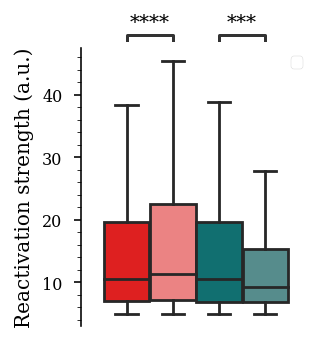

In [530]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
group_colors = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "superficial_pfc": "#568c8c",
}

sns.set_palette(sns.color_palette(group_colors.values()))

df_strength["constant"] = 1

sns.boxplot(
    x="constant",
    hue="single_cross_region_label",
    hue_order=group_colors.keys(),
    y="strength",
    showfliers=False,
    data=df_strength[
        (df_strength.sig == 1)
        & (df_strength.strength > 5)
        & (df_strength.single_cross_region_label != "unknown")
        & (df_strength.epoch == "post")
    ],
    saturation=1
)
# plt.yscale("log")
sns.despine(bottom=True)
plt.legend("")
plt.ylabel("Reactivation strength (a.u.)")
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

plt.gca().set_xticklabels([])
plt.gca().set_xticks([])
plt.gca().set_xlabel("")

box_pairs = [
    ((1, "deep_mec"), (1, "superficial_mec")),
    ((1, "deep_pfc"), (1, "superficial_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df_strength[
        (df_strength.sig == 1)
        & (df_strength.strength > 5)
        & (df_strength.single_cross_region_label != "unknown")
        & (df_strength.epoch == "post")
    ],
    x="constant",
    y="strength",
    hue="single_cross_region_label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

plt.savefig(
    os.path.join(fig_save_path, "prop_cross_region_reactivation.svg"),
    dpi=300,
    bbox_inches="tight",
)

## save csv for comparison in R


In [537]:
# add animal id
for basepath in df_strength.basepath.unique():
    df_strength.loc[df_strength.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)

In [538]:
df_strength[
    (df_strength.sig == 1)
    & (df_strength.strength > 5)
    & (df_strength.single_cross_region_label != "unknown")
    & (df_strength.epoch == "post")
].to_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_react_df.csv"
)


In [327]:
# df_strength[(df_strength.sig==1) & (df_strength.strength > 5) & (df_strength.single_cross_region_label != 'unknown')].basepath.value_counts()

## pre to post anova

In [311]:
import pingouin as pg

df_strength["unique_id"] = (
    df_strength.basepath
    + "_"
    + df_strength.assembly_n.astype(str)
)

aov = pg.mixed_anova(
    data=df_strength[
        (df_strength.sig == 1)
        & (df_strength.strength > 5)
        & (df_strength.epoch != "task")
        & (df_strength.single_cross_region_label.str.contains("pfc"))
    ],
    dv="strength",
    between="single_cross_region_label",
    within="epoch",
    subject="unique_id",
)
pg.print_table(aov)

aov = pg.mixed_anova(
    data=df_strength[
        (df_strength.sig == 1)
        & (df_strength.strength > 5)
        & (df_strength.epoch != "task")
        & (df_strength.single_cross_region_label.str.contains("mec"))
    ],
    dv="strength",
    between="single_cross_region_label",
    within="epoch",
    subject="unique_id",
)
pg.print_table(aov)



ANOVA SUMMARY

Source                         SS    DF1    DF2      MS      F    p-unc    np2      eps
-------------------------  ------  -----  -----  ------  -----  -------  -----  -------
single_cross_region_label  21.228      1     20  21.228  0.720    0.406  0.035  nan
epoch                      55.364      1     20  55.364  2.165    0.157  0.098    1.000
Interaction                 6.190      1     20   6.190  0.242    0.628  0.012  nan


ANOVA SUMMARY

Source                            SS    DF1    DF2         MS      F    p-unc    np2      eps
-------------------------  ---------  -----  -----  ---------  -----  -------  -----  -------
single_cross_region_label  16060.294      1     57  16060.294  2.374    0.129  0.040  nan
epoch                       1016.524      1     57   1016.524  1.571    0.215  0.027    1.000
Interaction                 1572.946      1     57   1572.946  2.431    0.124  0.041  nan



## pre to post pairs with assembly strength per cross region assembly

#### manually calculate pre post ratio

In [313]:
# def get_ratio(a,b):
#     return (a-b)/(a+b)

# pre_post_ratio = []
# basepaths = []
# assembly_ns = []
# single_cross_region_labels = []
# df_strength_temp = df_strength[(df_strength.sig==1) & (df_strength.strength > 5) & (df_strength.single_cross_region_label != 'unknown')]
# # basepath loop
# for basepath in df_strength_temp.basepath.unique():
#     # assembly loop
#     for assembly_n in df_strength_temp[
#         (df_strength_temp.basepath == basepath)
#     ].assembly_n.unique():
#         # cross region loop
#         for single_cross_region_label in df_strength_temp[
#             (df_strength_temp.basepath == basepath) & (df_strength_temp.assembly_n == assembly_n)
#         ].single_cross_region_label.unique():
#             # find pre values
#             pre = df_strength_temp[
#                 (df_strength_temp.basepath == basepath)
#                 & (df_strength_temp.assembly_n == assembly_n)
#                 & (df_strength_temp.single_cross_region_label == single_cross_region_label)
#                 & (df_strength_temp.epoch == "pre")
#             ].strength
#             # find post values
#             post = df_strength_temp[
#                 (df_strength_temp.basepath == basepath)
#                 & (df_strength_temp.assembly_n == assembly_n)
#                 & (df_strength_temp.single_cross_region_label == single_cross_region_label)
#                 & (df_strength_temp.epoch == "post")
#             ].strength
#             # calculate ratio
#             pre_post_ratio.append(get_ratio(np.nanmedian(post),np.nanmedian(pre)))
#             basepaths.append(basepath)
#             assembly_ns.append(assembly_n)
#             single_cross_region_labels.append(single_cross_region_label)


In [322]:
# test_df = pd.DataFrame(
#     {
#         "basepath": basepaths,
#         "assembly_n": assembly_ns,
#         "single_cross_region_label": single_cross_region_labels,
#         "pre_post_ratio": pre_post_ratio,
#     }
# )
# sns.boxplot(x="single_cross_region_label", y="pre_post_ratio", data=test_df,showfliers=False)
# sns.stripplot(x="single_cross_region_label", y="pre_post_ratio", data=test_df, color="k", dodge=True)
# plt.axhline(0, color="k", linestyle="--")

# box_pairs = [
#     ("deep_mec","superficial_mec"),
#     ("deep_pfc","superficial_pfc"),
# ]
# annotator = Annotator(plt.gca(), box_pairs, data=test_df, x="single_cross_region_label", y="pre_post_ratio")
# annotator.configure(test='t-test_ind', text_format='star', loc='outside',comparisons_correction=None,verbose=1)
# annotator.apply_and_annotate()
# plt.show()

### use pivot table to calculate pre post ratio

In [532]:
df_strength["above_strength_thres"] = df_strength.strength.values > 5

df_strength_pivot = (
    df_strength[(df_strength.sig == 1) & (df_strength.above_strength_thres) & (df_strength.single_cross_region_label != 'unknown')]
    .pivot_table(
        index=["basepath", "assembly_n"],
        columns=["single_cross_region_label", "epoch"],
        values="strength",
        aggfunc=np.nanmedian,
    )
    .reset_index()
)

# calculate pre post ratios
df_strength_pivot["pre_post_deep_mec"] = (
    df_strength_pivot["deep_mec"]["post"] - df_strength_pivot["deep_mec"]["pre"]
) / (df_strength_pivot["deep_mec"]["pre"] + df_strength_pivot["deep_mec"]["post"])

df_strength_pivot["pre_post_deep_pfc"] = (
    df_strength_pivot["deep_pfc"]["post"] - df_strength_pivot["deep_pfc"]["pre"]
) / (df_strength_pivot["deep_pfc"]["pre"] + df_strength_pivot["deep_pfc"]["post"])

df_strength_pivot["pre_post_superficial_mec"] = (
    df_strength_pivot["superficial_mec"]["post"] - df_strength_pivot["superficial_mec"]["pre"]
) / (df_strength_pivot["superficial_mec"]["pre"] + df_strength_pivot["superficial_mec"]["post"])

df_strength_pivot["pre_post_superficial_pfc"] = (
    df_strength_pivot["superficial_pfc"]["post"] - df_strength_pivot["superficial_pfc"]["pre"]
) / (df_strength_pivot["superficial_pfc"]["pre"] + df_strength_pivot["superficial_pfc"]["post"])
df_strength_pivot


single_cross_region_label                             basepath assembly_n  \
epoch                                                                       
0                                    Z:\Data\AYAold\AYA7\day19        2.0   
1                                    Z:\Data\AYAold\AYA7\day20        0.0   
2                                    Z:\Data\AYAold\AYA7\day20        1.0   
3                                    Z:\Data\AYAold\AYA7\day20        2.0   
4                                    Z:\Data\AYAold\AYA7\day20        4.0   
..                                                         ...        ...   
78                                 Z:\Data\Kenji\ec016.950_965        0.0   
79                         Z:\Data\Kenji\i01_maze01_MS.001_003        2.0   
80                         Z:\Data\Kenji\i01_maze01_MS.001_003        3.0   
81                                 Z:\Data\ORproject\OR18\day1        0.0   
82                                 Z:\Data\ORproject\OR18\day2        7.0   

single_cross_region_label   deep_mec                         deep_pfc  \
epoch                           post        pre       task       post   
0                           7.164906  15.711709  14.373373        NaN   
1                           9.692366  11.147501   6.625499        NaN   
2                                NaN        NaN  70.112006        NaN   
3                          11.285722   9.064667  21.488672        NaN   
4                          13.417260  14.030260  12.729230        NaN   
..                               ...        ...        ...        ...   
78                         15.522353  14.326167  23.371375        NaN   
79                               NaN        NaN        NaN        NaN   
80                               NaN        NaN        NaN        NaN   
81                               NaN        NaN        NaN        NaN   
82                               NaN        NaN        NaN  14.443619   

single_cross_region_label                      superficial_mec             \
epoch                            pre      task            post        pre   
0                                NaN       NaN             NaN        NaN   
1                                NaN       NaN             NaN        NaN   
2                                NaN       NaN             NaN        NaN   
3                                NaN       NaN             NaN        NaN   
4                                NaN       NaN             NaN        NaN   
..                               ...       ...             ...        ...   
78                               NaN       NaN             NaN        NaN   
79                               NaN       NaN       10.373737  10.208399   
80                               NaN       NaN       11.455643  10.172229   
81                               NaN       NaN             NaN        NaN   
82                         10.896076  9.488868             NaN        NaN   

single_cross_region_label            superficial_pfc                  \
epoch                           task            post        pre task   
0                                NaN             NaN        NaN  NaN   
1                                NaN             NaN        NaN  NaN   
2                                NaN             NaN        NaN  NaN   
3                                NaN             NaN        NaN  NaN   
4                                NaN             NaN        NaN  NaN   
..                               ...             ...        ...  ...   
78                               NaN             NaN        NaN  NaN   
79                          8.523875             NaN        NaN  NaN   
80                         10.328519             NaN        NaN  NaN   
81                               NaN       11.126986  10.905047  NaN   
82                               NaN             NaN        NaN  NaN   

single_cross_region_label pre_post_deep_mec pre_post_deep_pfc  \
epoch                                       

In [533]:
df_strength_pivot_long = pd.DataFrame()
df_strength_pivot_long["pre_post_ratio"] = np.hstack([
    df_strength_pivot.pre_post_deep_mec.values,
    df_strength_pivot.pre_post_deep_pfc.values,
    df_strength_pivot.pre_post_superficial_mec.values,
    df_strength_pivot.pre_post_superficial_pfc.values,
])
df_strength_pivot_long["basepath"] = np.hstack([
    df_strength_pivot.basepath.values,
    df_strength_pivot.basepath.values,
    df_strength_pivot.basepath.values,
    df_strength_pivot.basepath.values,
])
df_strength_pivot_long["assembly_n"] = np.hstack([
    df_strength_pivot.assembly_n.values,
    df_strength_pivot.assembly_n.values,
    df_strength_pivot.assembly_n.values,
    df_strength_pivot.assembly_n.values,
])
df_strength_pivot_long["single_cross_region_label"] = np.hstack([
    ['deep_mec']*len(df_strength_pivot.basepath.values),
    ['deep_pfc']*len(df_strength_pivot.basepath.values),
    ['superficial_mec']*len(df_strength_pivot.basepath.values),
    ['superficial_pfc']*len(df_strength_pivot.basepath.values),
])
df_strength_pivot_long["constant"] = 1

df_strength_pivot_long

,pre_post_ratio,basepath,assembly_n,single_cross_region_label,constant
0,-0.373604,Z:\Data\AYAold\AYA7\day19,2.0,deep_mec,1
1,-0.069825,Z:\Data\AYAold\AYA7\day20,0.0,deep_mec,1
2,NaN,Z:\Data\AYAold\AYA7\day20,1.0,deep_mec,1
3,0.109141,Z:\Data\AYAold\AYA7\day20,2.0,deep_mec,1
4,-0.022334,Z:\Data\AYAold\AYA7\day20,4.0,deep_mec,1
...,...,...,...,...,...
327,NaN,Z:\Data\Kenji\ec016.950_965,0.0,superficial_pfc,1
328,NaN,Z:\Data\Kenji\i01_maze01_MS.001_003,2.0,superficial_pfc,1
329,NaN,Z:\Data\Kenji\i01_maze01_MS.001_003,3.0,superficial_pfc,1
330,0.010073,Z:\Data\ORproject\OR18\day1,0.0,superficial_pfc,1


In [534]:
df_strength_pivot_long[~np.isnan(df_strength_pivot_long.pre_post_ratio) & (df_strength_pivot_long.single_cross_region_label == 'superficial_pfc')]

,pre_post_ratio,basepath,assembly_n,single_cross_region_label,constant
288,0.016954,Z:\Data\HMC1\day12,31.0,superficial_pfc,1
330,0.010073,Z:\Data\ORproject\OR18\day1,0.0,superficial_pfc,1


In [535]:
df_strength_pivot_long

,pre_post_ratio,basepath,assembly_n,single_cross_region_label,constant
0,-0.373604,Z:\Data\AYAold\AYA7\day19,2.0,deep_mec,1
1,-0.069825,Z:\Data\AYAold\AYA7\day20,0.0,deep_mec,1
2,NaN,Z:\Data\AYAold\AYA7\day20,1.0,deep_mec,1
3,0.109141,Z:\Data\AYAold\AYA7\day20,2.0,deep_mec,1
4,-0.022334,Z:\Data\AYAold\AYA7\day20,4.0,deep_mec,1
...,...,...,...,...,...
327,NaN,Z:\Data\Kenji\ec016.950_965,0.0,superficial_pfc,1
328,NaN,Z:\Data\Kenji\i01_maze01_MS.001_003,2.0,superficial_pfc,1
329,NaN,Z:\Data\Kenji\i01_maze01_MS.001_003,3.0,superficial_pfc,1
330,0.010073,Z:\Data\ORproject\OR18\day1,0.0,superficial_pfc,1


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_deep_pfc vs. 1_superficial_pfc: t-test independent samples, P_val:7.909e-01 t=2.688e-01
1_deep_mec vs. 1_superficial_mec: t-test independent samples, P_val:1.095e-01 t=-1.627e+00


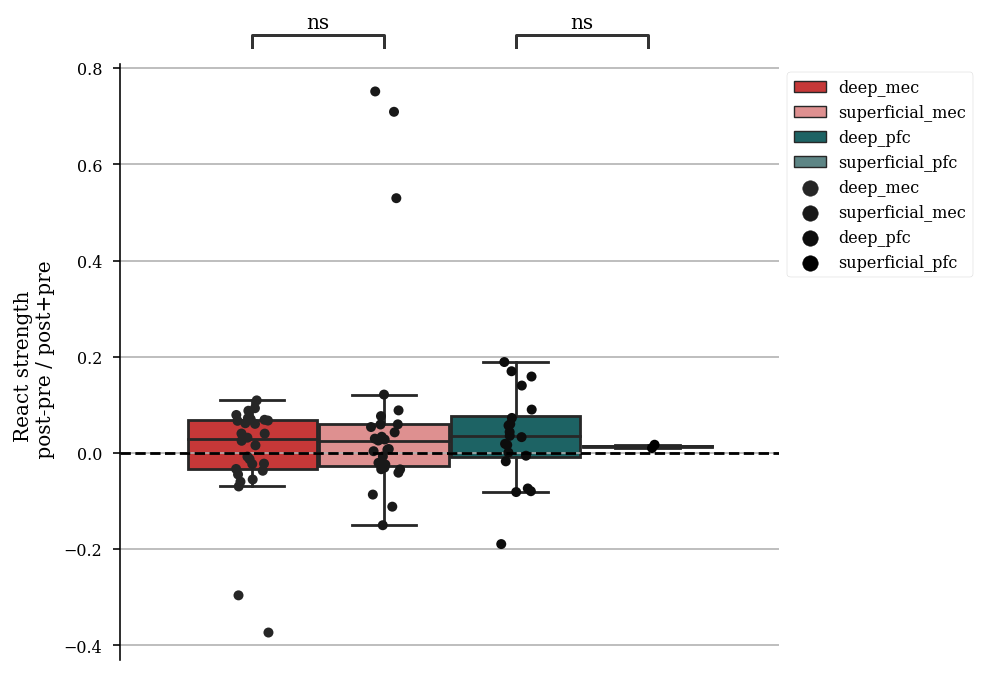

In [536]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=1, subplots=(1.5, 1)), edgecolor=None
)
group_colors = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "superficial_pfc": "#568c8c",
}

sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    data=df_strength_pivot_long,
    x="constant",
    hue="single_cross_region_label",
    hue_order=group_colors.keys(),
    y="pre_post_ratio",
    showfliers=False,
)
sns.stripplot(
    data=df_strength_pivot_long,
    x="constant",
    hue="single_cross_region_label",
    hue_order=group_colors.keys(),
    y="pre_post_ratio",
    color="black",
    dodge=True,
)
sns.despine(bottom=True)
plt.grid()
plt.axhline(0, color="k", linestyle="--", zorder=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel("React strength \n post-pre / post+pre")

box_pairs = [
    ((1, "deep_mec"), (1, "superficial_mec")),
    ((1, "deep_pfc"), (1, "superficial_pfc")),
]
annotator = Annotator(plt.gca(), box_pairs, data=df_strength_pivot_long, x="constant", y="pre_post_ratio", hue="single_cross_region_label",hue_order=group_colors.keys())
annotator.configure(test='t-test_ind', text_format='star', loc='outside',comparisons_correction=None,verbose=1)
annotator.apply_and_annotate()

plt.show()
# t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal.


In [ ]:
df_strength_pivot_long.basepath.unique()

# assembly example plot

In [481]:
import pickle
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day12.pkl"
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day8.pkl"
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day9.pkl"
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day10.pkl" # one deep pfc assembly
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day12.pkl"
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day13.pkl"

# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_AYAold_AYA9_day15.pkl"

# Z:\Data\AYAold\AYA9\day15
with open(session, "rb") as f:
    results = pickle.load(f)

In [482]:
# patterns = results["react"].patterns
# ar = results["react"]

patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)

In [483]:
# sort by groups
cm = results.get("react").cell_metrics[["brainRegion","deepSuperficial"]].copy()
cm.loc[cm.brainRegion.str.contains("CA1"),"brainRegion"] = "CA1"
cm["brainRegion_with_layer"] = cm.brainRegion + "_" + cm.deepSuperficial
cm.brainRegion_with_layer.unique()

array(['PFC_Cortical', 'CA1_Deep', 'CA1_Superficial', 'MEC_Cortical'],
      dtype=object)

In [484]:
idx = np.argsort(cm.brainRegion_with_layer.values)
patterns = patterns[:,idx]
is_member_sig = is_member_sig[:,idx]
cm = cm.iloc[idx]

In [485]:
group_colors = {
    "CA1_Deep": "#7b3294",
    "CA1_Superficial": "#008837",
    "MEC_Cortical": "#de2020",
    "PFC_Cortical": "#116f70",
}
# group_colors = {"deep": "#7b3294","sup": "#008837", "mixed": "grey"}

colors = np.tile(custom_plots.lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
for reg in group_colors.keys():
    # color by region
    idx = cm.brainRegion_with_layer.str.contains(reg).values
    colors[:,idx] = [group_colors[reg]] * sum(idx)
    # color by deep/sup
    # idx = cm.deepSuperficial.str.contains(reg).values
    # colors[:,idx] = [group_colors[reg]] * sum(idx)

for i in range(is_member_sig.shape[0]): 
    for j in range(is_member_sig.shape[1]):
        if is_member_sig[i,j] != 1:
            colors[i,j] = custom_plots.lighten_color(colors[i,j],0.5)

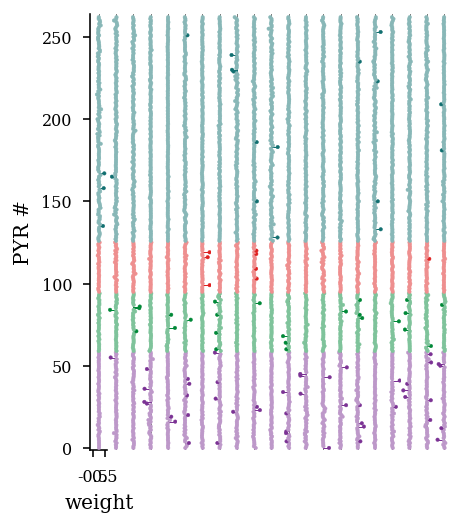

In [503]:

fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=.55, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors[i,:],zorder=1000,s=3,rasterized=True)

    # axs[i].scatter(assmbl,np.arange(len(assmbl)),zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[i,j],zorder=-50,linewidth=0.5,rasterized=True)

    axs[i].axvline(0,color='grey',zorder=-100,linewidth=0.5)

for i in range(patterns.shape[0]):
    axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].set_ylim(-1.5,patterns.shape[1]+1)

for i in range(patterns.shape[0]):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)  
    axs[i].patch.set_alpha(0)
    
for i in np.arange(1,patterns.shape[0]):
    axs[i].spines["left"].set_visible(False)  
    axs[i].spines["bottom"].set_visible(False)      
    axs[i].get_yaxis().set_ticks([])
    axs[i].get_xaxis().set_ticks([])

axs[0].set_ylabel('PYR #')
axs[0].set_xlabel('weight')
axs[0].set_xticks([-0.5,.5])
axs[0].set_xticklabels([-0.5,.5])

plt.savefig(
    os.path.join(fig_save_path, "cross_region_assembly_weights.svg"),
    dpi=500,
    bbox_inches="tight",
    transparent=True
)
plt.show()

In [211]:
# df_strength_pivot[]

# df_strength_pivot["constant"] = 1
# df_strength_pivot.pivot(columns='constant', values=['pre_post_deep_mec', 'pre_post_deep_pfc', 'pre_post_superficial_mec', 'pre_post_superficial_pfc'])

In [208]:
# only take strength above 5 within ripple
# df_strength["above_strength_thres"] = df_strength.strength.values > 5

# df_strength_pivot = df_strength[(df_strength.sig==1) & (df_strength.above_strength_thres)].pivot(
#         index=["basepath","assembly_n","ripple_n","single_cross_region_label"],
#         columns="epoch",
#         values="strength",
# ).reset_index()
# df_strength_pivot["pre_post"] = (df_strength_pivot['post'] - df_strength_pivot['pre']) / (df_strength_pivot['pre'] + df_strength_pivot['post'])
# # df_strength_pivot["pre_post"] = (df_strength_pivot['pre'] / df_strength_pivot['post'])
# df_strength_pivot["constant"] = 1
# df_strength_pivot

In [209]:
# print(df_strength_pivot[~np.isnan(df_strength_pivot.pre_post.values)].basepath.value_counts()[:8])
# print("")
# print(df_strength_pivot[~np.isnan(df_strength_pivot.pre_post.values)].single_cross_region_label.value_counts())

In [210]:
# fig = plt.figure(
#     figsize=functions.set_size("thesis", fraction=1, subplots=(1, 1)), edgecolor=None
# )
# group_colors = {
#     "deep_mec": "#de2020",
#     "superficial_mec": "#eb8383",
#     "deep_pfc": "#116f70",
#     "superficial_pfc": "#568c8c",
# }

# sns.set_palette(sns.color_palette(group_colors.values()))

# sns.boxplot(
#     x="constant",
#     y="pre_post",
#     hue="single_cross_region_label",
#     hue_order=group_colors.keys(),
#     data=df_strength_pivot,
#     showfliers=False,
# )
# sns.stripplot(
#     x="constant",
#     y="pre_post",
#     hue="single_cross_region_label",
#     data=df_strength_pivot,
#     dodge=True,
#     color="k",
#     alpha=.25,
# )
# # plt.yscale("log")
# sns.despine(bottom=True)
# plt.grid()
# plt.axhline(0,color='k',linestyle='--',zorder=100)
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.ylabel("React strength \n post-pre / post+pre")
# box_pairs = [
#     ((1, "deep_mec"), (1, "superficial_mec")),
#     ((1, "deep_pfc"), (1, "superficial_pfc")),
# ]
# add_stat_annotation(
#     plt.gca(),
#     x="constant",
#     y="pre_post",
#     hue="single_cross_region_label",
#     data=df_strength_pivot,
#     hue_order=group_colors.keys(),
#     box_pairs=box_pairs,
#     test="Mann-Whitney",
#     text_format="star",
#     loc="outside",
#     verbose=0,
#     comparisons_correction=None
# )
# plt.show()

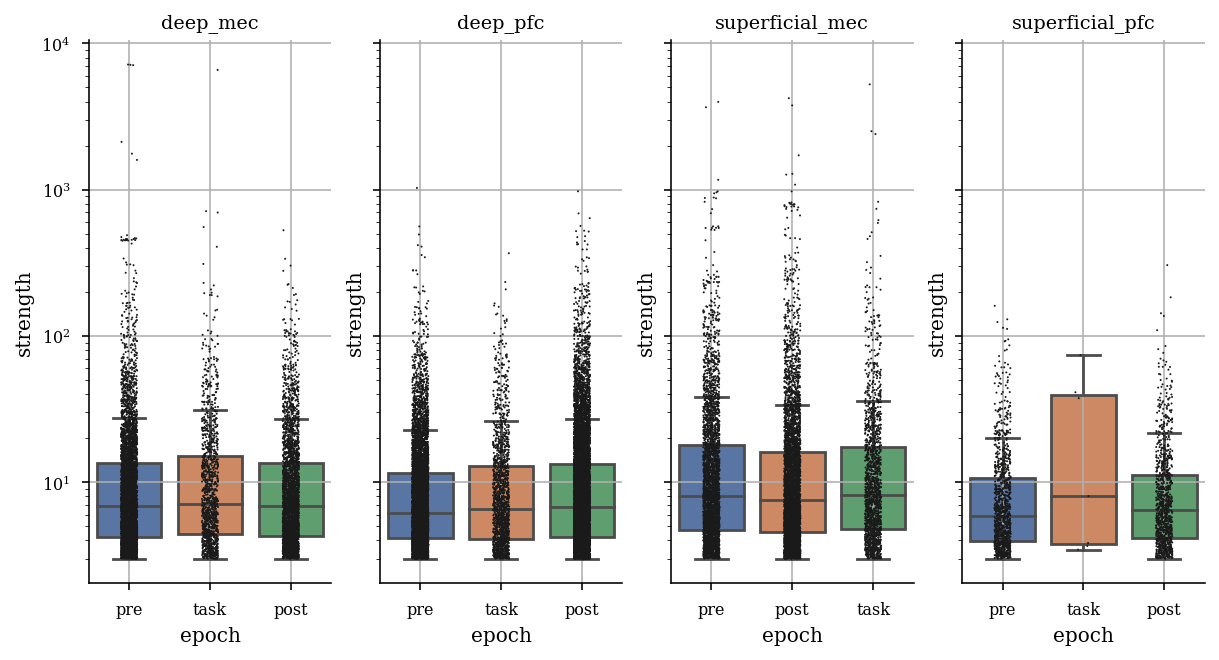

In [298]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5), sharey=True)

for i, label in enumerate(labels):
    sns.boxplot(
        x="epoch",
        y="strength",
        data=df_strength[
            (df_strength.strength > 3)
            & (df_strength[label])
            & (df_strength.sig)
            & (df_strength.single_cross_region)
        ],
        ax=ax[i],
        showfliers=False,
    )
    sns.stripplot(
        x="epoch",
        y="strength",
        data=df_strength[
            (df_strength.strength > 3)
            & (df_strength[label])
            & (df_strength.sig)
            & (df_strength.single_cross_region)
        ],
        ax=ax[i],
        dodge=True,
        color="k",
        size=1,
    )
    ax[i].set_title(label)
    ax[i].set_yscale("log")
    ax[i].grid()
sns.despine()


# Testing below

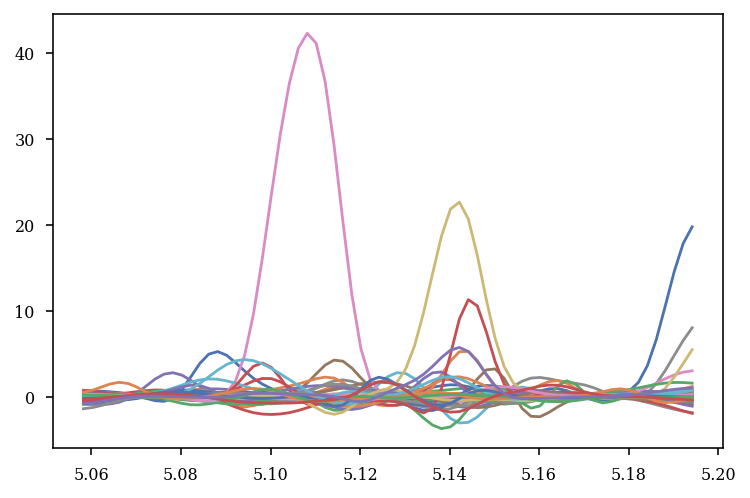

In [137]:
sns.set_palette(sns.color_palette("deep"))

plt.plot(
    results["assembly_act_pre"][results["react"].ripples[0]].abscissa_vals,
    results["assembly_act_pre"][results["react"].ripples[0]].data.T,
)

plt.show()


In [233]:
import pickle
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_HMC1_day10.pkl"
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_AYAold_AYA9_day15.pkl"

# Z:\Data\AYAold\AYA9\day15
with open(session, "rb") as f:
    results = pickle.load(f)

In [238]:
results['react'].patterns.shape, results['react'].st

((17, 102), <SpikeTrainArray at 0x24823d7b8e0: 102 units> at 20000 Hz)

In [234]:
results['react'].basepath

'Z:\\Data\\AYAold\\AYA9\\day15'

## locate deep_pfc, deep_mec, sup_pfc, sup_mec assemblies

In [24]:
# results.get("react").cell_metrics.deep
for ims in is_member_sig:
    print(results.get("react").cell_metrics.brainRegion.values[ims])

['PFC' 'PFC' 'PFC']
['PFC' 'CA1sp' 'CA1sp']
['CA1sp' 'CA1sp' 'CA1sp']
['CA1so' 'CA1sp' 'CA1sp' 'CA1sp']
['CA1sp' 'CA1sp' 'CA1so' 'CA1sr']
['PFC' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sp' 'CA1sp' 'CA1so']
['MEC' 'MEC' 'MEC']
['CA1sp' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sr' 'CA1sp' 'CA1so' 'CA1sr']
['PFC' 'PFC' 'PFC' 'CA1so']
['PFC' 'PFC' 'CA1so' 'CA1sp' 'CA1sp' 'MEC' 'MEC' 'MEC' 'MEC']
['PFC' 'PFC']
['CA1sp' 'CA1so' 'CA1sp' 'CA1sr' 'CA1so' 'CA1so' 'CA1so' 'CA1so']
['CA1sp' 'CA1sp' 'CA1sp']
['CA1so' 'CA1so']
['CA1sp' 'CA1sp' 'CA1sr']
['PFC' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sp' 'CA1so' 'CA1so' 'CA1sr']
['PFC' 'PFC' 'PFC' 'PFC']
['CA1sp' 'CA1sp' 'CA1sp']
['CA1sp' 'CA1sr' 'CA1sp' 'CA1sp' 'CA1sr' 'CA1sp']
['CA1so' 'CA1so' 'CA1sr' 'CA1so' 'CA1sp' 'MEC']
['PFC' 'PFC' 'CA1sp' 'CA1so' 'CA1sp' 'CA1sp' 'CA1sp']


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


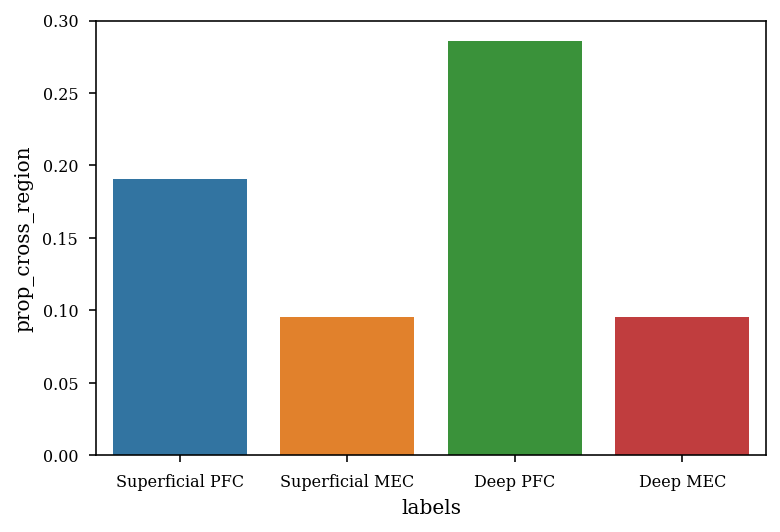

In [42]:
def compile_results_df(results):

    patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(results.get("react").patterns)


    assembly_df = pd.DataFrame()
    assembly_df["patterns"] = patterns.ravel()
    assembly_df["is_member_sig"] = is_member_sig.ravel()
    assembly_df["assembly_n"] = (np.ones_like(patterns).T * np.arange(patterns.shape[0])).T.astype(int).ravel()
    assembly_df["UID"] = np.tile(results.get("react").cell_metrics.UID.values, patterns.shape[0])
    assembly_df["putativeCellType"] = np.tile(results.get("react").cell_metrics.putativeCellType.values, patterns.shape[0])
    assembly_df["brainRegion"] = np.tile(results.get("react").cell_metrics.brainRegion.values, patterns.shape[0])
    assembly_df["deepSuperficial"] = np.tile(results.get("react").cell_metrics.deepSuperficial.values, patterns.shape[0])
    assembly_df["deepSuperficialDistance"] = np.tile(results.get("react").cell_metrics.deepSuperficialDistance.values, patterns.shape[0])
    assembly_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(assembly_df)

    deep_mec = []
    deep_pfc = []
    superficial_mec = []
    superficial_pfc = []

    for n in assembly_df.assembly_n.unique():
        temp_assembly_df = assembly_df[
            (assembly_df.assembly_n == n) & (assembly_df.is_member_sig)
        ]
        deep_mec.append(
            any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
            & any((temp_assembly_df.deepSuperficial == "Deep"))
        )
        deep_pfc.append(
            any(temp_assembly_df.brainRegion.str.contains("PFC"))
            & any((temp_assembly_df.deepSuperficial == "Deep"))
        )
        superficial_mec.append(
            any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
            & any((temp_assembly_df.deepSuperficial == "Superficial"))
        )
        superficial_pfc.append(
            any(temp_assembly_df.brainRegion.str.contains("PFC"))
            & any((temp_assembly_df.deepSuperficial == "Superficial"))
        )

    prop_df = pd.DataFrame()
    prop_df["prop_cross_region"] = [
        np.mean(np.array(superficial_pfc) > 0),
        np.mean(np.array(superficial_mec) > 0),
        np.mean(np.array(deep_pfc) > 0),
        np.mean(np.array(deep_mec) > 0),
    ]
    prop_df["labels"] = ["Superficial PFC", "Superficial MEC", "Deep PFC", "Deep MEC"]

    results.get("react").cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(results.get("react").cell_metrics)

    prop_df["n_deep"] = sum(results.get("react").cell_metrics.deepSuperficial == "Deep")
    prop_df["n_sup"] = sum(results.get("react").cell_metrics.deepSuperficial == "Superficial")
    prop_df["n_mec"] = sum(results.get("react").cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
    prop_df["n_pfc"] = sum(results.get("react").cell_metrics.brainRegion.str.contains("PFC"))
    prop_df["n_assemblies"] = len(assembly_df.assembly_n.unique())
    prop_df["basepath"] = results.get("react").basepath

    return prop_df, assembly_df


prop_df, assembly_df = compile_results_df(results)
ax = sns.barplot(x="labels", y="prop_cross_region", data=prop_df)

In [41]:
results.get("react").basepath

'Z:\\Data\\HMC1\\day10'

In [49]:
def get_pre_post_assembly_strengths(basepath,verbose=False):
    """
    Gets the pre and post assembly strengths
    """
    # initialize session
    m1 = assembly_reactivation.AssemblyReact(
        basepath,
        brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC",
        putativeCellType="Pyr",
        weight_dt=0.02,
    )

    # load data
    m1.load_data()
    # check if no cells were found
    if m1.cell_metrics.shape[0] == 0:
        return None
    # restrict to pre/task/post epochs
    m1.restrict_epochs_to_pre_task_post()
    # get weights for task outside ripples
    # % (TODO: use more robust method to locate epochs than index)
    if verbose:
        print("Getting weights...")
    m1.get_weights(m1.epochs[1][~m1.ripples])

    # get assembly activity
    if verbose:
        print("Getting assembly activity...")
    assembly_act_pre = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[0]])
    assembly_act_task = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[1]])
    assembly_act_post = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[2]])
    results = {
        "assembly_act_pre": assembly_act_pre,
        "assembly_act_task": assembly_act_task,
        "assembly_act_post": assembly_act_post,
        "react": m1,
    }

    return results


basepath = r"Z:\Data\FujisawaS\EE\EE0708fm"
results = get_pre_post_assembly_strengths(basepath,verbose=True)

Getting weights...
Getting assembly activity...


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than

(102,)

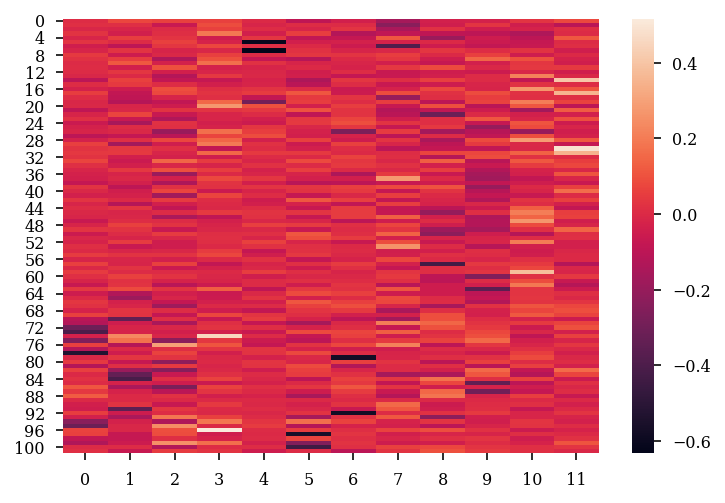

In [64]:
results["react"].patterns.shape
dir(results["react"])

results["react"].cell_metrics.shape

sns.heatmap(results["react"].patterns.T)

results["react"].cell_metrics.brainRegion.shape

In [65]:
ar = results["react"]

In [5]:
basepath = r"Z:\Data\HMC1\day13"

ar = assembly_reactivation.AssemblyReact(basepath, brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC",
        putativeCellType="Pyr")
ar.load_data()
ar.restrict_epochs_to_pre_task_post()

# ar.get_weights([ar.ripples.expand(0.2)])
ar.get_weights([ar.epochs[1]])


In [ ]:
# ar = assembly_reactivation.AssemblyReact(basepath, brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC",
#         putativeCellType="Pyr")
# ar.load_data()
# ar.ripples = ar.ripples.expand(0.2)
basepath = r"Z:\Data\FujisawaS\EE\EE0708fm"

results = assembly_reactivation.get_pre_post_assembly_strengths(basepath)

In [66]:
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(ar.patterns)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [79]:
is_member

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [67]:
patterns.shape, is_member_sig.shape, np.array(keep_assembly).shape, is_member.shape

((6, 102), (6, 102), (12,), (12, 102))

In [68]:
assembly_df = pd.DataFrame()
assembly_df["patterns"] = patterns.ravel()
assembly_df["is_member_sig"] = is_member_sig.ravel()
assembly_df["assembly_n"] = (np.ones_like(patterns).T * np.arange(patterns.shape[0])).T.astype(int).ravel()
assembly_df["UID"] = np.tile(ar.cell_metrics.UID.values, patterns.shape[0])
assembly_df["putativeCellType"] = np.tile(ar.cell_metrics.putativeCellType.values, patterns.shape[0])
assembly_df["brainRegion"] = np.tile(ar.cell_metrics.brainRegion.values, patterns.shape[0])
assembly_df["deepSuperficial"] = np.tile(ar.cell_metrics.deepSuperficial.values, patterns.shape[0])
assembly_df["deepSuperficialDistance"] = np.tile(ar.cell_metrics.deepSuperficialDistance.values, patterns.shape[0])
assembly_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(assembly_df)

assembly_df

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
0,0.006238,False,0,41,Pyramidal Cell,PFC,Cortical,NaN
1,0.017089,False,0,49,Pyramidal Cell,PFC,Cortical,NaN
2,-0.011791,False,0,50,Pyramidal Cell,PFC,Cortical,NaN
3,0.027435,False,0,62,Pyramidal Cell,PFC,Cortical,NaN
4,-0.014103,False,0,63,Pyramidal Cell,PFC,Cortical,NaN
...,...,...,...,...,...,...,...,...
607,-0.003268,False,5,358,Pyramidal Cell,CA1,Deep,-176.695637
608,0.022124,False,5,359,Pyramidal Cell,CA1,Deep,-156.695637
609,0.103919,False,5,361,Pyramidal Cell,CA1,Deep,-96.695637
610,0.028437,False,5,362,Pyramidal Cell,CA1,Deep,-136.695637


In [69]:
# target_regions = 

for n in assembly_df.assembly_n.unique():
    for ca1_sub in ["Deep", "Superficial"]:
        for region in ["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]:
            
            source_idx = any(
                (assembly_df.assembly_n == n)
                & (assembly_df.is_member_sig)
                & (assembly_df.deepSuperficial == ca1_sub)
            )
            targ_idx = any(
                (assembly_df.assembly_n == n)
                & (assembly_df.is_member_sig)
                & assembly_df.brainRegion.str.contains(region)
            )
            if source_idx & targ_idx:
                assembly_df.loc[assembly_df.assembly_n == n, "cross_region"] = (
                    ca1_sub + "_" + region
                )
            else:
                assembly_df.loc[assembly_df.assembly_n == n, "cross_region"] = "None"


In [70]:
sum(assembly_df.cross_region == "Superficial_EC1|EC2|EC3|EC4|EC5|MEC") / assembly_df.shape[0]
assembly_df.cross_region.value_counts()

None    612
Name: cross_region, dtype: int64

In [22]:
assembly_df[assembly_df.brainRegion.str.contains(region) | (assembly_df.deepSuperficial == "Deep")]

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance
135,0.022262,False,0,272,Pyramidal Cell,CA1so,Deep,-150.0000
136,0.005076,False,0,274,Pyramidal Cell,CA1so,Deep,-30.0000
138,0.012666,False,0,279,Pyramidal Cell,CA1so,Deep,-130.7624
139,0.040901,False,0,281,Pyramidal Cell,CA1so,Deep,-105.0000
140,-0.016030,False,0,283,Pyramidal Cell,CA1so,Deep,-70.7624
...,...,...,...,...,...,...,...,...
6694,-0.028502,False,20,540,Pyramidal Cell,MEC,Cortical,NaN
6695,-0.005852,False,20,541,Pyramidal Cell,MEC,Cortical,NaN
6696,0.008489,False,20,542,Pyramidal Cell,MEC,Cortical,NaN
6697,0.006120,False,20,546,Pyramidal Cell,MEC,Cortical,NaN


In [71]:
deep_mec = []
deep_pfc = []
superficial_mec = []
superficial_pfc = []

for n in assembly_df.assembly_n.unique():
    temp_assembly_df = assembly_df[
        (assembly_df.assembly_n == n) & (assembly_df.is_member_sig)
    ]
    deep_mec.append(
        any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
        & any((temp_assembly_df.deepSuperficial == "Deep"))
    )
    deep_pfc.append(
        any(temp_assembly_df.brainRegion.str.contains("PFC"))
        & any((temp_assembly_df.deepSuperficial == "Deep"))
    )
    superficial_mec.append(
        any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"))
        & any((temp_assembly_df.deepSuperficial == "Superficial"))
    )
    superficial_pfc.append(
        any(temp_assembly_df.brainRegion.str.contains("PFC"))
        & any((temp_assembly_df.deepSuperficial == "Superficial"))
    )


In [11]:
any(temp_assembly_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC")) & any((temp_assembly_df.deepSuperficial == "Deep"))

False

In [72]:
temp_assembly_df

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,cross_region
524,0.405214,True,5,102,Pyramidal Cell,PFC,Cortical,NaN,None
527,0.351466,True,5,105,Pyramidal Cell,PFC,Cortical,NaN,None
540,0.487538,True,5,143,Pyramidal Cell,PFC,Cortical,NaN,None
541,0.350603,True,5,144,Pyramidal Cell,PFC,Cortical,NaN,None


In [41]:
assembly_df[(assembly_df.assembly_n == 9) & (assembly_df.is_member_sig)]

,patterns,is_member_sig,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,cross_region
2913,0.154188,True,9,61,Pyramidal Cell,PFC,Cortical,NaN,None
2982,0.152820,True,9,176,Pyramidal Cell,PFC,Cortical,NaN,None
3023,0.224849,True,9,297,Pyramidal Cell,CA1sr,Superficial,49.23760,None
3056,0.139360,True,9,343,Pyramidal Cell,CA1sp,Superficial,73.05757,None
3111,0.179650,True,9,411,Pyramidal Cell,CA1so,Deep,-100.76240,None
3116,0.172396,True,9,419,Pyramidal Cell,CA1sp,middle,-10.76240,None
3118,0.230774,True,9,421,Pyramidal Cell,CA1so,Deep,-115.76240,None
3122,0.368816,True,9,425,Pyramidal Cell,CA1sp,middle,0.00000,None
3124,0.545400,True,9,429,Pyramidal Cell,CA1so,Deep,-40.76240,None


Text(0.5, 1.0, 'Number of cells in each assembly')

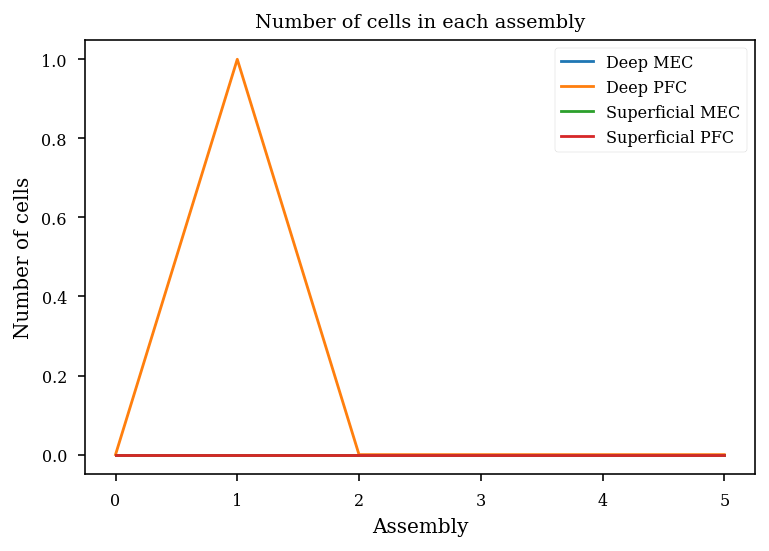

In [73]:
plt.plot(deep_mec)
plt.plot(deep_pfc)
plt.plot(superficial_mec)
plt.plot(superficial_pfc)
plt.legend(["Deep MEC", "Deep PFC", "Superficial MEC", "Superficial PFC"])
plt.xlabel("Assembly")
plt.ylabel("Number of cells")
plt.title("Number of cells in each assembly")


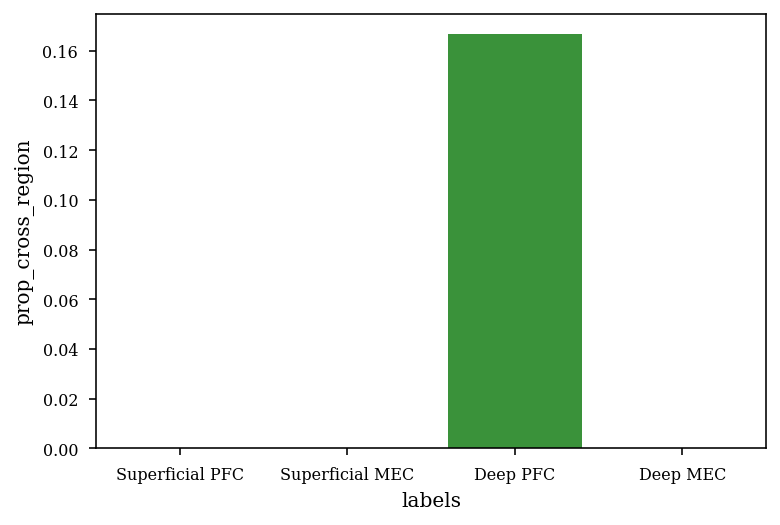

In [74]:
temp_df = pd.DataFrame()

temp_df["prop_cross_region"] = [
    np.mean(np.array(superficial_pfc) > 0),
    np.mean(np.array(superficial_mec) > 0),
    np.mean(np.array(deep_pfc) > 0),
    np.mean(np.array(deep_mec) > 0),
]
temp_df["labels"] = ["Superficial PFC", "Superficial MEC", "Deep PFC", "Deep MEC"]

ax = sns.barplot(x="labels", y="prop_cross_region", data=temp_df)

In [75]:
temp_df

,prop_cross_region,labels
0,0.000000,Superficial PFC
1,0.000000,Superficial MEC
2,0.166667,Deep PFC
3,0.000000,Deep MEC


In [15]:
def lighten_color(color, amount=0.5):
    """
    Lightens a color by a certain percentage.
    This is useful for adjusting colors for a particular element of a page.
    :param color: The hex color code, e.g. #AABBCC
    :param amount: The amount to lighten the color by.
    :return: The lightened color code in hex, e.g. #FFFFFF
    """
    try:
        c = color.lstrip('#')
        c = tuple(int(c[i:i + 2], 16) for i in (0, 2, 4))
        c = (
            int((1 - amount) * c[0] + amount * 255),
            int((1 - amount) * c[1] + amount * 255),
            int((1 - amount) * c[2] + amount * 255),
        )
        return '#%02x%02x%02x' % c
    except ValueError:
        return color

## plotting assemblies

In [76]:
group_colors = {
    "CA1": "#615766",
    "MEC": "#de2020",
    "PFC": "#116f70",
}

colors = np.tile(lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
for reg in group_colors.keys():
    idx = ar.cell_metrics.brainRegion.str.contains(reg).values
    colors[:,idx] = [group_colors[reg]] * sum(idx)

for i in range(is_member_sig.shape[0]): 
    for j in range(is_member_sig.shape[1]):
        if is_member_sig[i,j] != 1:
            colors[i,j] = lighten_color(colors[i,j],0.5)


[Text(-0.5, 0, '-0.5'), Text(0.5, 0, '0.5')]

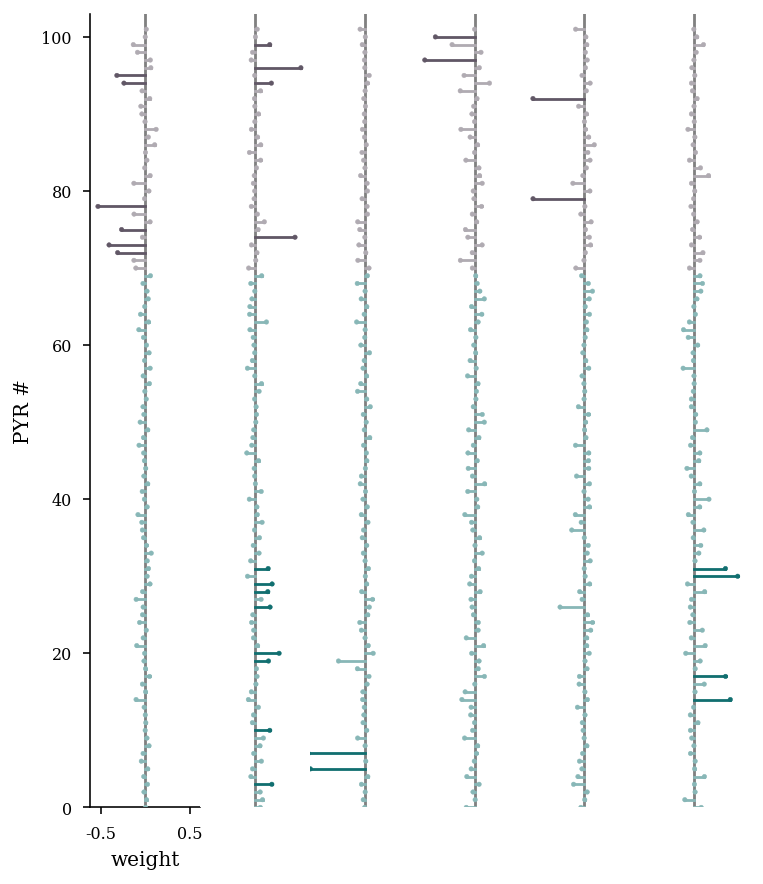

In [77]:
# patterns.shape
# colors = np.tile(lighten_color("#615766",.9), (patterns.shape[0],patterns.shape[1]))
# lighten_color("#615766",.9)
# colors[is_member_sig] = "#615766"

fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=1, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors[i,:],zorder=1000,s=5)

    # axs[i].scatter(assmbl,np.arange(len(assmbl)),zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[i,j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

for i in range(patterns.shape[0]):
    axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].set_ylim(0,patterns.shape[1]+1)

for i in range(patterns.shape[0]):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)  

for i in np.arange(1,patterns.shape[0]):
    axs[i].spines["left"].set_visible(False)  
    axs[i].spines["bottom"].set_visible(False)      
    axs[i].get_yaxis().set_ticks([])
    axs[i].get_xaxis().set_ticks([])

axs[0].set_ylabel('PYR #')
axs[0].set_xlabel('weight')
axs[0].set_xticks([-.5,.5])
axs[0].set_xticklabels([-.5,.5])
    

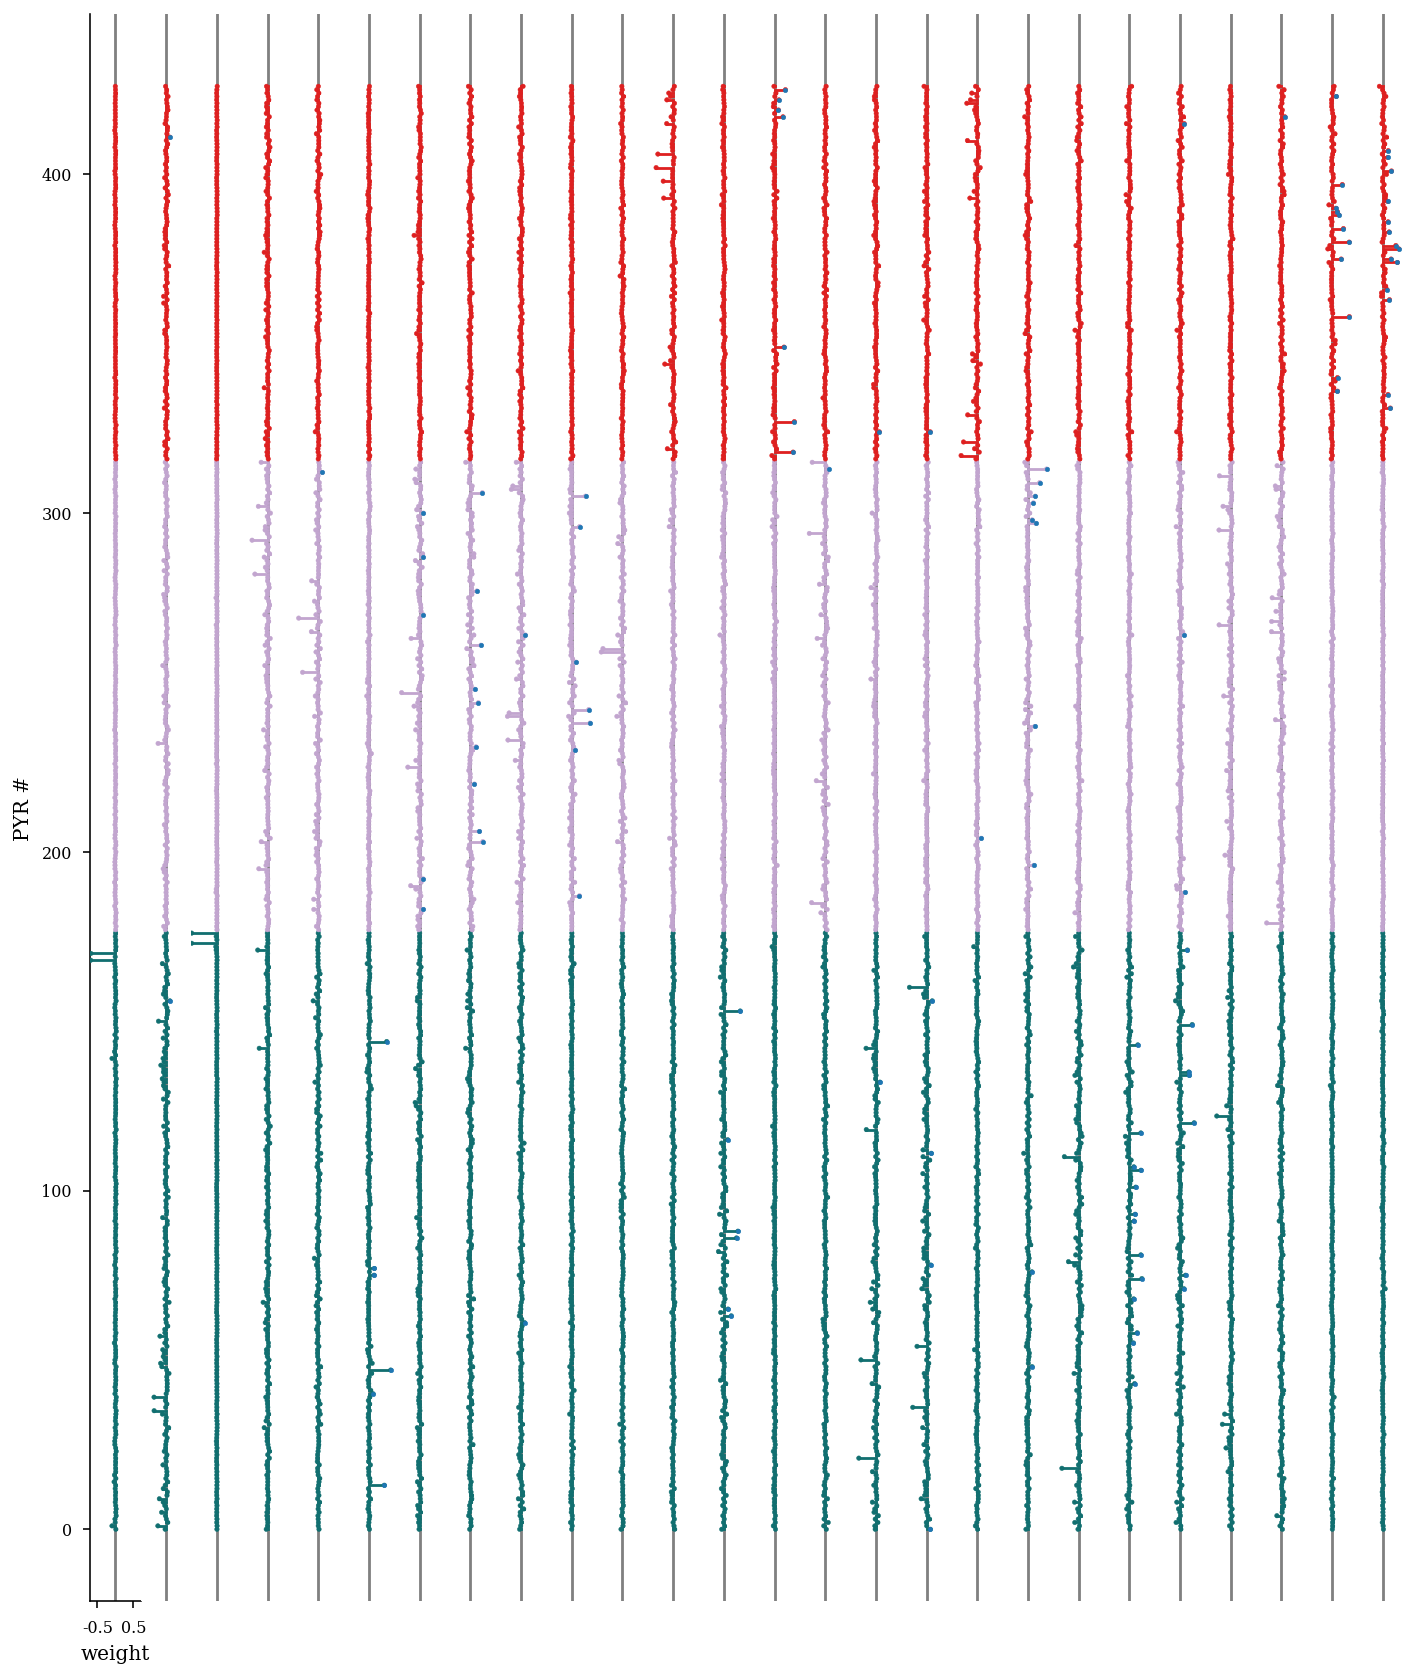

In [31]:
fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=2, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors,zorder=1000,s=5)

    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(assmbl[idx],np.arange(len(assmbl))[idx],zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[j],zorder=-50)
        if idx[j]:
            axs[i].plot(np.sort([item,0]),[j,j],color=colors_sig[j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

    for i in range(patterns.shape[0]):
        axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)

    for i in range(patterns.shape[0]):
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["top"].set_visible(False)  

    for i in np.arange(1,patterns.shape[0]):
        axs[i].spines["left"].set_visible(False)  
        axs[i].spines["bottom"].set_visible(False)      
        axs[i].get_yaxis().set_ticks([])
        axs[i].get_xaxis().set_ticks([])

    axs[0].set_ylabel('PYR #')
    axs[0].set_xlabel('weight')
    axs[0].set_xticks([-.5,.5])
    axs[0].set_xticklabels([-.5,.5])


<StemContainer object of 3 artists>

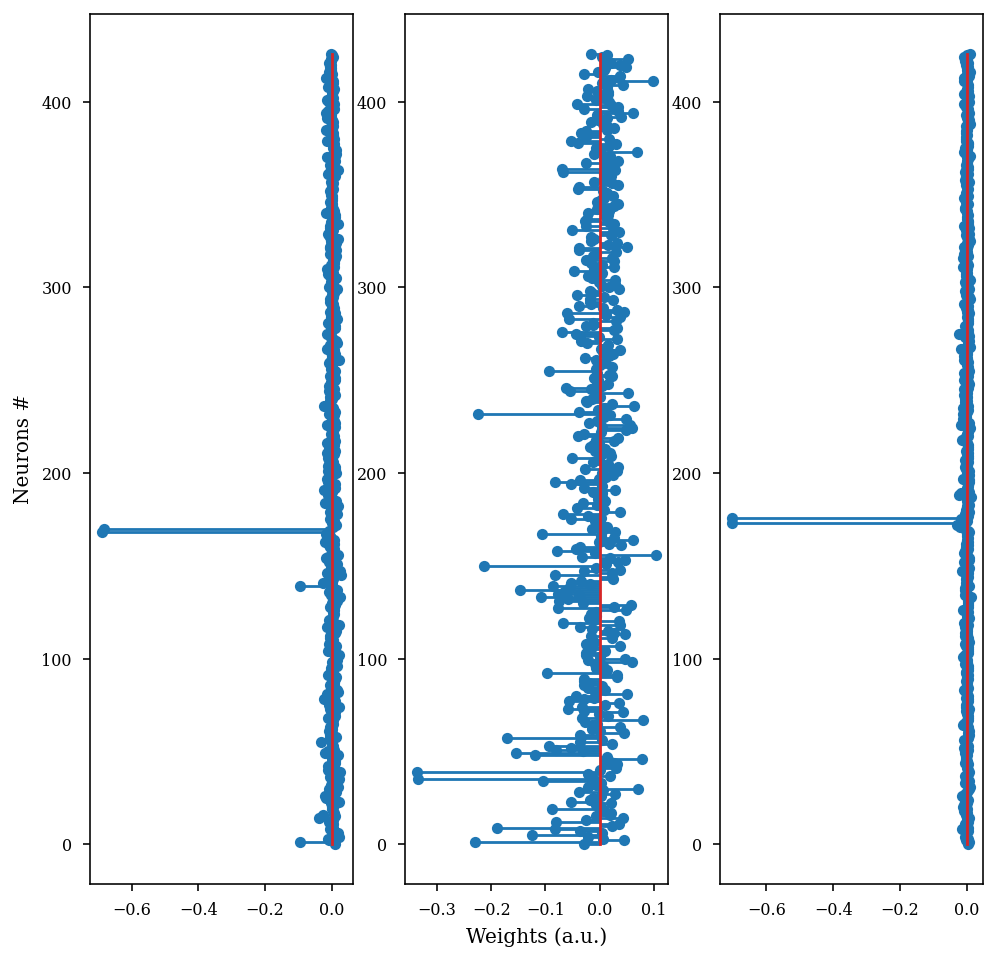

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
ax1 = plt.subplot(131)
plt.stem(patterns[0,:], orientation = 'horizontal')
ax1.set_ylabel('Neurons #')

ax2 = plt.subplot(132, sharey=ax1)
plt.stem(patterns[1,:], orientation = 'horizontal')
ax2.set_xlabel('Weights (a.u.)')

ax3 = plt.subplot(133, sharey=ax1)
plt.stem(patterns[2,:], orientation = 'horizontal')